# DTSA 5509 Supervised Learning Final Project

## Analysis of MMA Fighter Statistics

### Introduction
MMA was created to determine which fighting disciplines were the most effective in a combat setting. In the first UFC event most participants were experts in a single combat style such as boxing, wrestling, Brazilian jiu-jitsu, or even sumo wrestling, but in the current day all fighters train at least two martial arts and most train elements from several disciplines. For this reason, it would be very difficult to classify the specific style that helped a fighter to win a match or matches; however, it is much easier to record fighters’ proficiency in executing and defending takedowns, strikes, and submissions which are each used throughout many different combat disciplines.

The purpose of this report is to analyze real MMA fighters' physical attributes and career statistics to determine the most important skills and physical traits for MMA fighting. This is important to know because it can help current and prospective MMA fighters decide which skills are the most important to emphasize in practice. To accomplish this I will be creating a multiple linear regression model to perform a regression prediction task, specifically, I want to predict fighters' career winning percentage based of their proficiencies at various skills and their physical attributes.

The data set, [UFC Fighters’ Statistic Dataset]( https://www.kaggle.com/datasets/asaniczka/ufc-fighters-statistics/data) , tracks the wins, losses and draws of fighters; their physical attributes of height, weight, and reach, and several data points for strikes, takedowns and submissions. Overall, there are 4103 fighters career data with 14 numeric features and 3 categorical features. I got this data from Kaggle (Asaniczka, 2023). The data was collected from the UFC which records these statistics during each fight and publishes them following each event. 


Data Citation:

Asaniczka. (2023, December 8). UFC fighters’ statistics dataset. Kaggle. https://www.kaggle.com/datasets/asaniczka/ufc-fighters-statistics/data 


### Data Cleaning
After importing my data, I examined it to find any shortcomings that would need to be addressed with cleaning. The first thing that I did was to change the nicknames from string values and nulls to 1s and 0s. Each fighter with a nickname got a 1 and each fighter without a nickname got a 0. This change to categorical data allows me to more easily examine if performance differed amongst fighters with nicknames vs those fighters without; however, analysis of specific nicknames was outside of the scope of this project, and I also felt would likely be difficult to draw meaningful conclusions from. 

Following this change, I dropped the columns “date_of_birth” and “reach_in_cm”. I dropped the date of birth because the data spans decades and fighters were active at different times. Fighters start fighting at different ages and times, retire at different ages and their level of “activity” (the frequency they are fighting) varies over time. I do think an analysis of performance with age would yield interesting results and is a good place for further analysis, but this dataset lacked the granularity required to perform such an analysis. I was reluctant to drop the reach data because it is a significant factor used by commentators and analysts when talking about a fight and trying to predict fight outcomes, especially in striking sports. My expectation would be that fighters who favor a strike heavy fight style would benefit from greater reach; however, over half the reach data was missing. I was concerned that trying to interpolate the missing data would have questionable accuracy with such a large amount of the data missing. Furthermore, with this quantity of data missing I was also concerned that any attempt to fill the missing data with something like "an average reach by weight class" would potentially lead to deemphasizing the role reach plays in a fighters success if I were to do subsequent analysis with this “fixed” data. Ultimately I concluded that it would be better to focus my attention on other aspects of the data. Reach will be reflected in the final analysis indirectly because height tends to influence a person’s reach, so for my purposes I believe it will be acceptable to leave reach out of the data set.

For the fighters’ stances I added a sixth category to fill in for the missing data. I called this category “fluid” because the data was missing and upon manual search of several fighters I found no information on the specific stance they favored. My conclusion was that while some of this data was simply missing, of the 20 or so fighters I searched for manually a handful were orthodox or southpaw, many of these fighters tended to change their stance during and between fights making it difficult to classify a primary fighting stance. I declined to designate these fighters as “switch” stance fighters because my understanding is that the “switch” stance specifically refers to changing between orthodox and southpaw stances, the two most common stances.

I then added three columns to the data. The first two columns I added were win percentage and total fights. These two columns would allow me to examine the longevity and total success of a fighter and are made from simple calculations involving existing columns that were not missing any data. The total fights column was made by summing the wins, losses, and draws in a fighter’s career. Win percentage was calculated by summing the wins with .5* the draws and dividing by the total number of fights. This formula is commonly used in other sports, such as football, so I applied it here as well. The final column I added was the weight class column. This was created by classifying each fighters “weight_in_kg” into one of the 9 weight classes that the UFC sanctions and was populated with that weight classes maximum allowed weight in kilograms. I also dropped any fighters who were missing weight data as I had no way to import this information and it consisted of only 3% of the data.

After this I separated the data by weight class for potential use later and used this opportunity to correct my last column that was missing data, “height_cm”. Since the weight class of fighters tends to be heavily influenced by their height, I decided to fill in each missing height with the average of the fighter in that weight class. You can see this clear height stratification in the plot below. A note about the graph, I set the y-axis to start at 100 so that the trend of increasing height would be more easily seen. The average heights increase by 3-4cm per weight class but this can be hard to see visually when looking at bars that are 180+. I then concatenated the data frames back together and reset the indices to complete my data cleaning.



In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
import scienceplots
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [37]:
#import data
PATH = os.getcwd()
data_raw = pd.read_csv(PATH+'\\ufc-fighters-statistics.csv')
fighter_data = data_raw
print(data_raw)

#Clean data
# Make nicknames a 1 and no nicknames a 0. 
# For analysis purposes I only want to examine if the fighter has a nickname, so this changes to a categorical feature.
for x in range(len(fighter_data['nickname'])):
    z = fighter_data.at[x, 'nickname']
    if isinstance(z,float) == True:
        fighter_data.at[x, 'nickname'] = 0
    else:
        fighter_data.at[x, 'nickname'] = 1

#Remove Fighter Date of Birth
#I removed fighter birth days because it was not used in this analysis.
#The data spans decades, but because fighters continue to age as they fight and begin their careers
# at different ages and dates I believe I lack the data granularity in this data set to meaningfully analyze using birth days.
#Remove fighter reach data
#Fighter reach data could have been useful in analysis; however, half of the data on reach is missing
#With this quantity of missing data I did not feel I could accurately approximate the average reach of each weight class
fighter_data = fighter_data.drop(columns=['date_of_birth', 'reach_in_cm'])

#Change all nan values in the stance data to 'Fluid'
#I made this change because after researching several of the fighters without a stance in this data most of them did not have a listed stance I could find.
#I believe this is the reason for the nan values present here
fighter_data['stance'] = fighter_data['stance'].fillna(value='Fluid')

#This line calculates the total number of fights that a fighter has participated in
#With total fights we can analyze how fighting style and physical traits affect fighter longevity
fighter_data['total_fights'] = fighter_data.wins + fighter_data.losses + fighter_data.draws

#This line calculates the winning percentage of a fighter using the standard formula of:
#winning percentage = (wins+.5*draws)/total fights
# With win percentage we can determine the impact of fighting style and physical traits on fighter success
fighter_data['win_percentage'] = (fighter_data.wins + .5*fighter_data.draws)/fighter_data.total_fights

#Determine fighter weight classes
#If the figher does not have a weight then I dropped the row.
#When replacing other fighter data I used the weight class average; however, this is not possible without the baseline weight
fighter_data['weight_class'] = np.nan

for x in range(len(fighter_data['weight_in_kg'])):
    if fighter_data.at[x, 'weight_in_kg'] <= 52.2:
        fighter_data.at[x, 'weight_class'] = 52.2

    elif 52.2 < fighter_data.at[x, 'weight_in_kg'] <= 56.7:
        fighter_data.at[x, 'weight_class'] = 56.7

    elif 56.7 < fighter_data.at[x, 'weight_in_kg'] <= 61.25:
        fighter_data.at[x, 'weight_class'] = 61.2

    elif 61.25 < fighter_data.at[x, 'weight_in_kg'] <= 65.8:
        fighter_data.at[x, 'weight_class'] = 65.8

    elif 65.8 < fighter_data.at[x, 'weight_in_kg'] <= 70.31:
        fighter_data.at[x, 'weight_class'] = 70.3

    elif 70.31 < fighter_data.at[x, 'weight_in_kg'] <= 77.11:
        fighter_data.at[x, 'weight_class'] = 77.1

    elif 77.11 < fighter_data.at[x, 'weight_in_kg'] <= 83.91:
        fighter_data.at[x, 'weight_class'] = 83.9

    elif 83.91 < fighter_data.at[x, 'weight_in_kg'] <= 93:
        fighter_data.at[x, 'weight_class'] = 93

    elif 93 < fighter_data.at[x, 'weight_in_kg'] <= 120.2:
        fighter_data.at[x, 'weight_class'] = 120.2
    else:
        fighter_data = fighter_data.drop(index=x)

#Split data into weight classes, fix missing height data
strawweight = fighter_data[fighter_data['weight_class'] == 52.2]
strawweight['height_cm'] = strawweight['height_cm'].fillna(value = np.mean(strawweight['height_cm']))

flyweight = fighter_data[fighter_data['weight_class'] == 56.7]
flyweight['height_cm'] = flyweight['height_cm'].fillna(value = np.mean(flyweight['height_cm']))

bantamweight = fighter_data[fighter_data['weight_class'] == 61.2]
bantamweight['height_cm'] = bantamweight['height_cm'].fillna(value = np.mean(bantamweight['height_cm']))

featherweight = fighter_data[fighter_data['weight_class'] == 65.8]
featherweight['height_cm'] = featherweight['height_cm'].fillna(value = np.mean(featherweight['height_cm']))

lightweight = fighter_data[fighter_data['weight_class'] == 70.3]
lightweight['height_cm'] = lightweight['height_cm'].fillna(value = np.mean(lightweight['height_cm']))

welterweight = fighter_data[fighter_data['weight_class'] == 77.1]
welterweight['height_cm'] = welterweight['height_cm'].fillna(value = np.mean(welterweight['height_cm']))

middleweight = fighter_data[fighter_data['weight_class'] == 83.9]
middleweight['height_cm'] = middleweight['height_cm'].fillna(value = np.mean(middleweight['height_cm']))

light_heavyweight = fighter_data[fighter_data['weight_class'] == 93]
light_heavyweight['height_cm'] = light_heavyweight['height_cm'].fillna(value = np.mean(light_heavyweight['height_cm']))

heavyweight = fighter_data[fighter_data['weight_class'] == 120.2]
heavyweight['height_cm'] = heavyweight['height_cm'].fillna(value = np.mean(heavyweight['height_cm']))

#Update Fighter Data with the new height information
fighter_data = fighter_data[fighter_data['total_fights'] != 0]
fighter_data = pd.concat([strawweight, flyweight, bantamweight, featherweight, lightweight, welterweight, middleweight, light_heavyweight, heavyweight], axis=0).reset_index()
fighter_data = fighter_data.drop(columns=['index', 'weight_in_kg', 'name'])
print(fighter_data)

                    name                  nickname  wins  losses  draws  \
0           Rex Richards                       NaN     7       2      0   
1           Luana Santos                       NaN     6       1      0   
2     Cortavious Romious  Are You Not Entertained?     7       2      0   
3            Danny Silva                   El Puma     8       1      0   
4          Angel Pacheco                       NaN     7       2      0   
...                  ...                       ...   ...     ...    ...   
4104      Edgar Cardenas                Kitty Katt     4       1      0   
4105           Joe Veres                       NaN     4       3      0   
4106      Jordan Goodwin                       NaN     0       0      0   
4107     Robert Drysdale                       NaN     7       0      0   
4108       Shaun Etchell               The Buzzsaw     7       3      0   

      height_cm  weight_in_kg  reach_in_cm    stance date_of_birth  \
0        195.58        120.20

C:\Users\noahl\AppData\Local\Temp\ipykernel_24508\522903202.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strawweight['height_cm'] = strawweight['height_cm'].fillna(value = np.mean(strawweight['height_cm']))
C:\Users\noahl\AppData\Local\Temp\ipykernel_24508\522903202.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flyweight['height_cm'] = flyweight['height_cm'].fillna(value = np.mean(flyweight['height_cm']))
C:\Users\noahl\AppData\Local\Temp\ipykernel_24508\522903202.py:83: SettingWithCopyWarnin

Text(0.5, 1.0, 'Average Height by Weight Class')

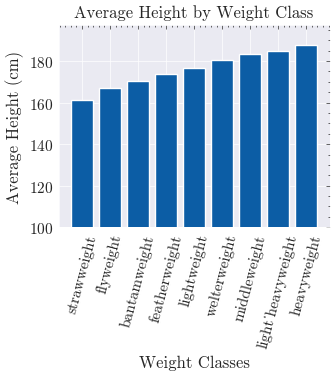

In [38]:
height_avgs = [np.mean(strawweight['height_cm']), np.mean(flyweight['height_cm']), np.mean(bantamweight['height_cm']), np.mean(featherweight['height_cm']),
                    np.mean(lightweight['height_cm']), np.mean(welterweight['height_cm']), np.mean(middleweight['height_cm']), 
                    np.mean(light_heavyweight['height_cm']), np.mean(heavyweight['height_cm'])]

classes = ['strawweight', 'flyweight', 'bantamweight', 'featherweight', 'lightweight', 'welterweight', 'middleweight', 'light_heavyweight', 'heavyweight']

plt.style.use(['science', 'no-latex', 'std-colors'])
plt.bar(classes, height_avgs)
plt.ylim(ymin=100) 
plt.xticks(rotation=75)
plt.xlabel('Weight Classes')
plt.ylabel('Average Height (cm)')
plt.title('Average Height by Weight Class')


### Exploratory Data Analysis

For my exploratory data analysis, I first created a correlation coefficient heatmap from a correlation matrix and a pairplot to see what obvious correlations and patterns existed in the data as my data set was too large to see most patterns. In the correlation matrix I noticed several correlations that were very strong, some expected and some not. Wins and total fights being correlated makes sense because the more a fighter wins the longer his career would be expected to last. Another expected correlation was weight class and height because of the square-cube law the taller a person is the heavier they are expected to be. An unexpectedly strong correlation is the average submissions attempted per 15 minutes and the significant strikes landed per minute. These two were highly correlated, with a 1.00 correlation coefficient meaning that across all fighters the more active they were with striking the more active they were with submission attempts, always. This does not make sense, at least not with this level of correlation. After reviewing the data it appears that the two columns are duplicates of one another. Significant strikes do not count as submission attempts and vice versa, and one set is per minute interval while the other is per 15 minute interval; therefore, it is presumed that one of the two columns is erroneous. I choose to keep the significant strikes per minute data and drop the submission attempts per 15 minutes data because after examining recent UFC event statistics it seemed more plausible to me. You can also see this extremely strong correlation in the pairplot which appears to be a near perfect line for the two variables.


Across the board there was not a particularly strong correlation between fighting style and win totals. The strongest correlation was significant strike defense which is a logical thing as the ability to avoid potential knockout punches would understandably make someone less likely to lose. The next highest correlation for fighting style and winning was takedown defense. Taken together this would indicate that fighters with good defensive abilities tend to win more often than fighters who lacked in defensive skills. After examining these correlations with wins I decided it made more sense to look at win percentage rather than the raw number of wins. A major factor is that not every fighter in this analysis has retired, so the win total could be artificially reduced by incomplete data. Fighters also choose to retire at different points in their career and many retire “early”, which is perceived by fans as when they are still having success. Finally, we are primarily concerned with the fighter success and therefore a success rate measure like win percentage is more likely to give us insights into how fighting styles translate into success. 


Another reason I decided to look at winning percentage is the correlation with losses. Total wins actually has a positive correlation with losses, somewhat counterintuitively, but when a fighter wins more he tends to fight more fights and even a good fighter will lose some of their fights meaning that total losses tends to increase as total wins increases. This is often the case in sports where the coaches or players with the most wins also have the most losses. In contrast, winning percentage has a relatively strong negative correlation with losses because it is adjusted for total fights.


C:\Users\noahl\AppData\Local\Temp\ipykernel_24508\3007739429.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  p1 = sns.heatmap(fighter_data.corr(), annot=True, fmt = ".2f", cmap = "plasma")


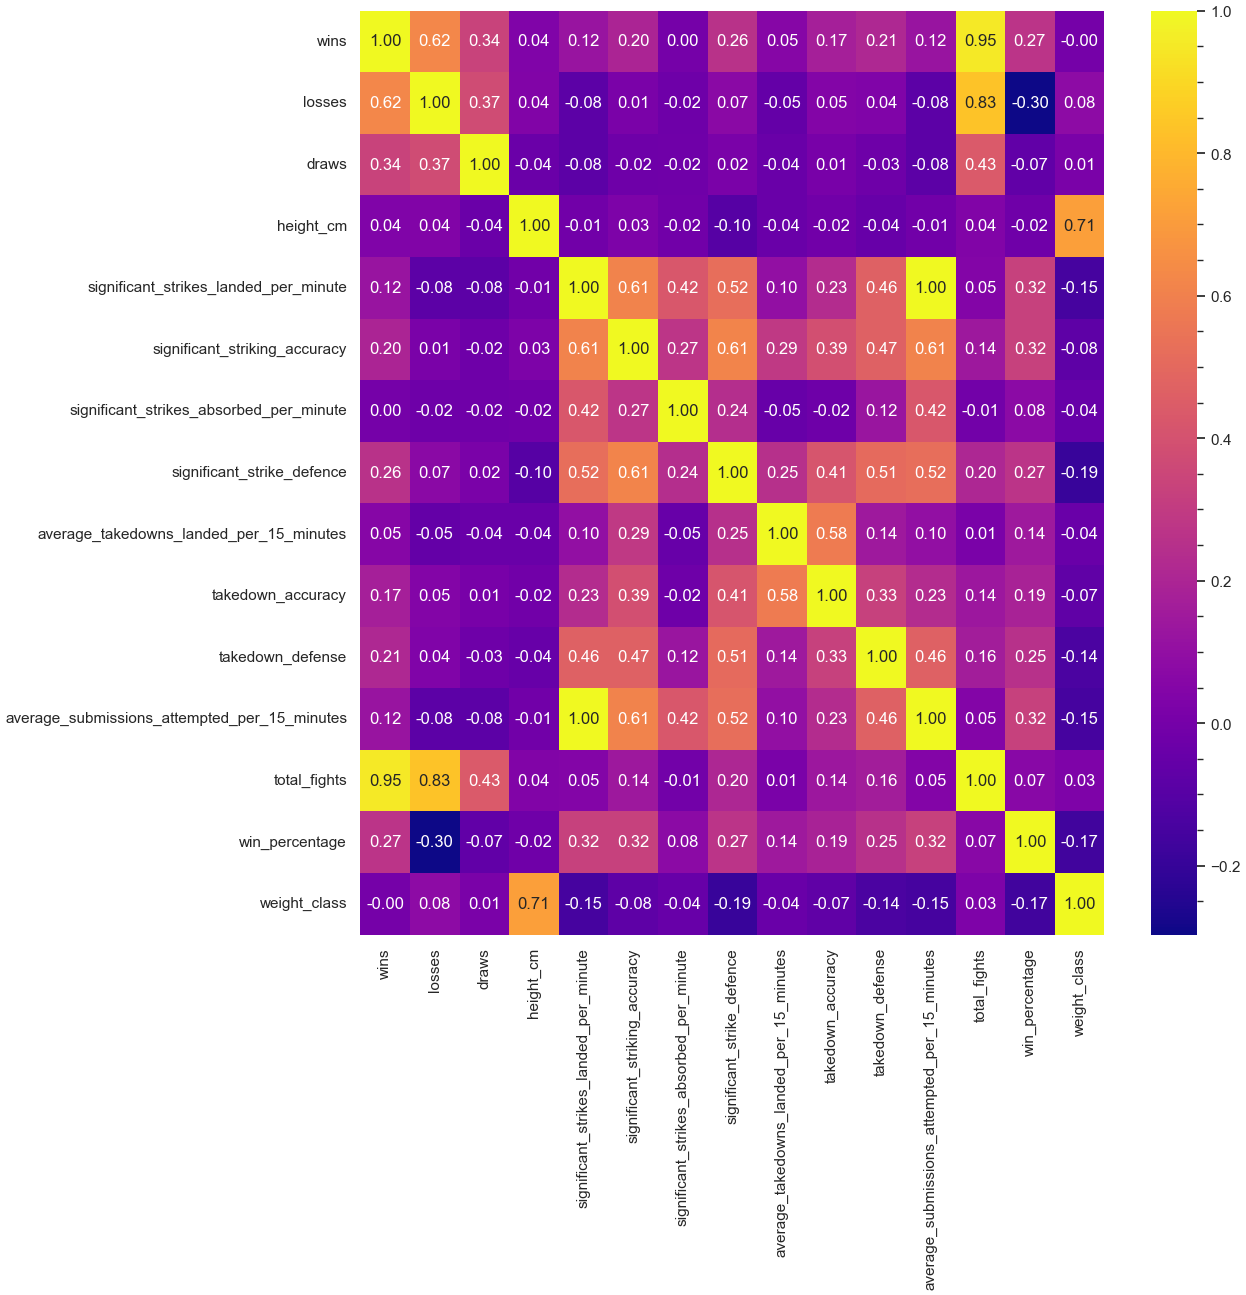

In [29]:
#correlation matrix
p1 = sns.heatmap(fighter_data.corr(), annot=True, fmt = ".2f", cmap = "plasma")
sns.set(rc={'figure.figsize':(12,12)})
p1.tick_params(axis = 'x', rotation = 90)
p1.tick_params(axis = 'y', rotation = 0)

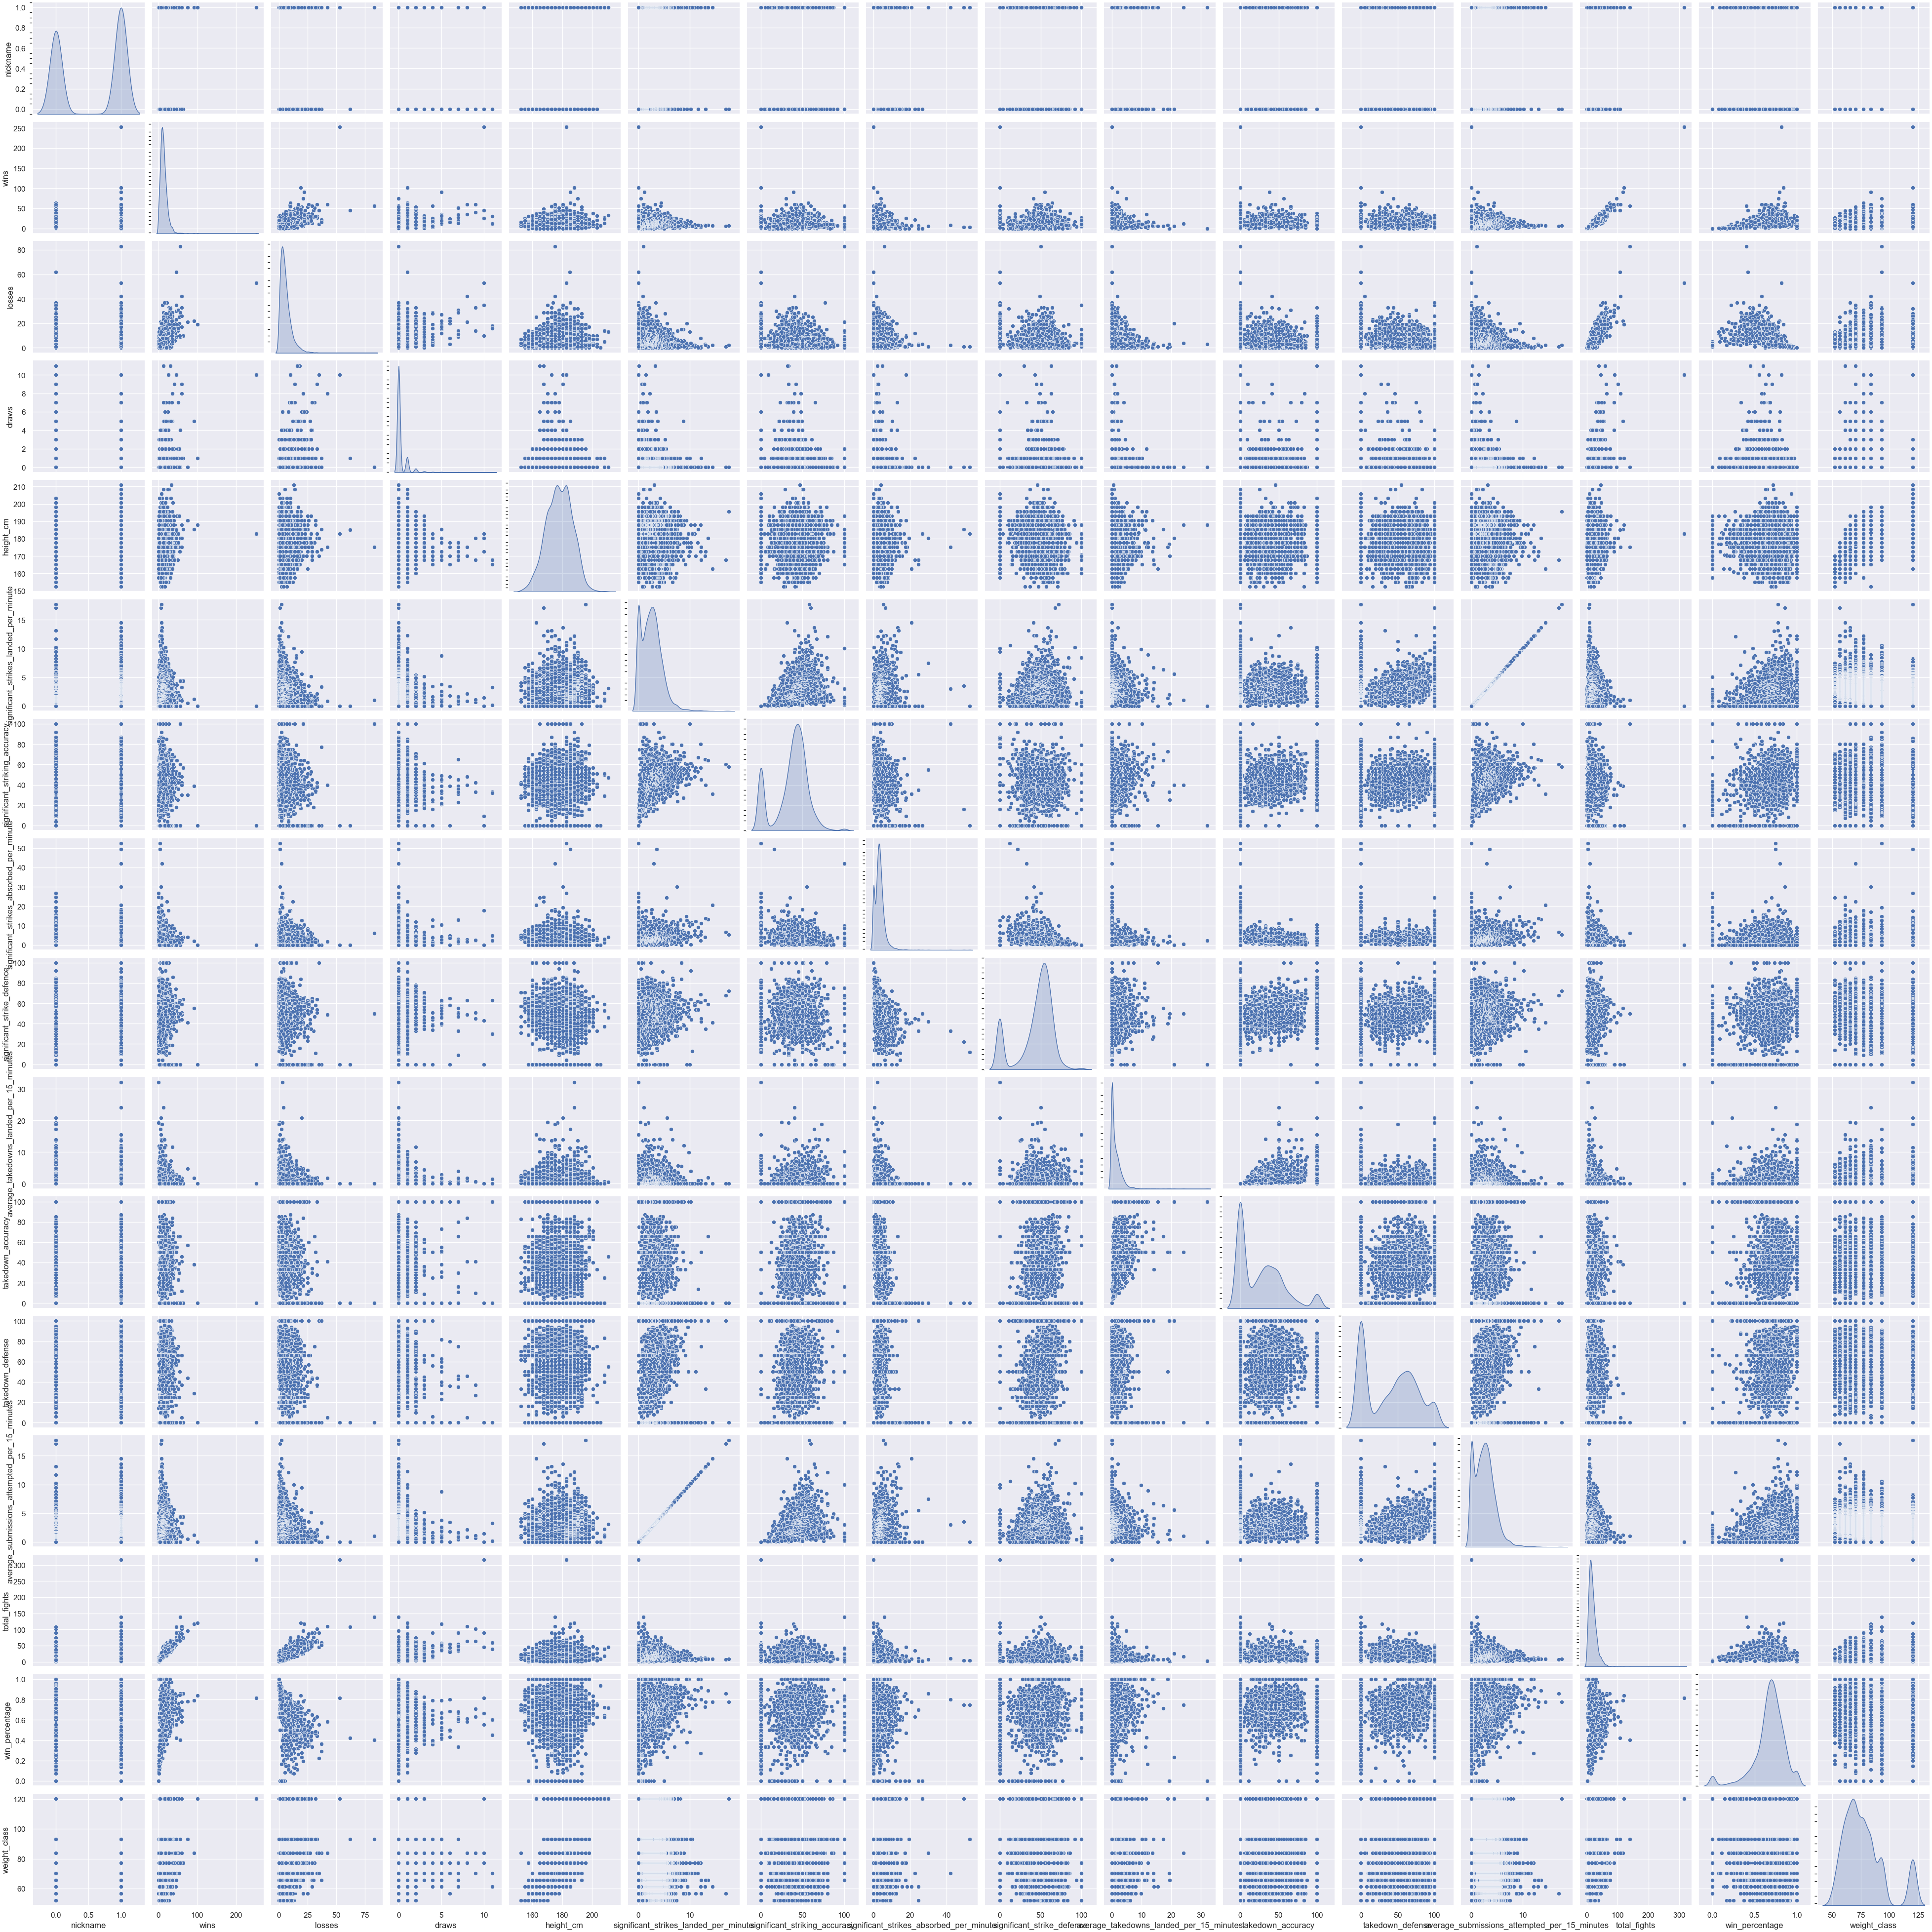

In [30]:
#Pairplot
p2 = sns.pairplot(fighter_data, diag_kind='kde')
sns.set_context("notebook", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})

Text(0.5, 1.0, 'Significant Strikes vs Submissions Attempted')

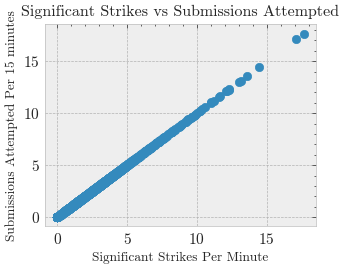

In [39]:
plt.style.use(['bmh'])
font = {'size'   : 8}

matplotlib.rc('font', **font)
plt.scatter(fighter_data['significant_strikes_landed_per_minute'], fighter_data['average_submissions_attempted_per_15_minutes'])
plt.xlabel('Significant Strikes Per Minute')
plt.ylabel('Submissions Attempted Per 15 minutes')
plt.title('Significant Strikes vs Submissions Attempted')

After completing this EDA my final features used for analysis were winning percentage, total fights, height, weight class, significant strikes landed per minute, significant strike accuracy, significant strikes absorbed per minute, significant strike defense, takedowns landed per 15 minutes, takedown accuracy, and takedown defense. After choosing this dataset I created a new pairplot and correlation coefficient heatmap to allow for better readability now that the feature count has been reduced from 18 to 11. Based off this heatmap the only collinearity that might be present is the relationship between weight class and height. It is expected that these two variables are strongly related, and the correlation coefficient is borderline at .71 with the “problematic” zone for collinearity beginning at .70. I will examine further during model building to see if this is an issue. With these more easily decipherable diagnostic plots I dropped a major outlier on the total fights column which was over 100% more fights than the next closest fighter at the time of the data collection. This outlier was Travis Fulton, who at the time of this data had 316 sanctioned MMA fights, the most in recorded history by over 150 fights, even today. I did not want an outlier this extreme to have outsized influence over the model.

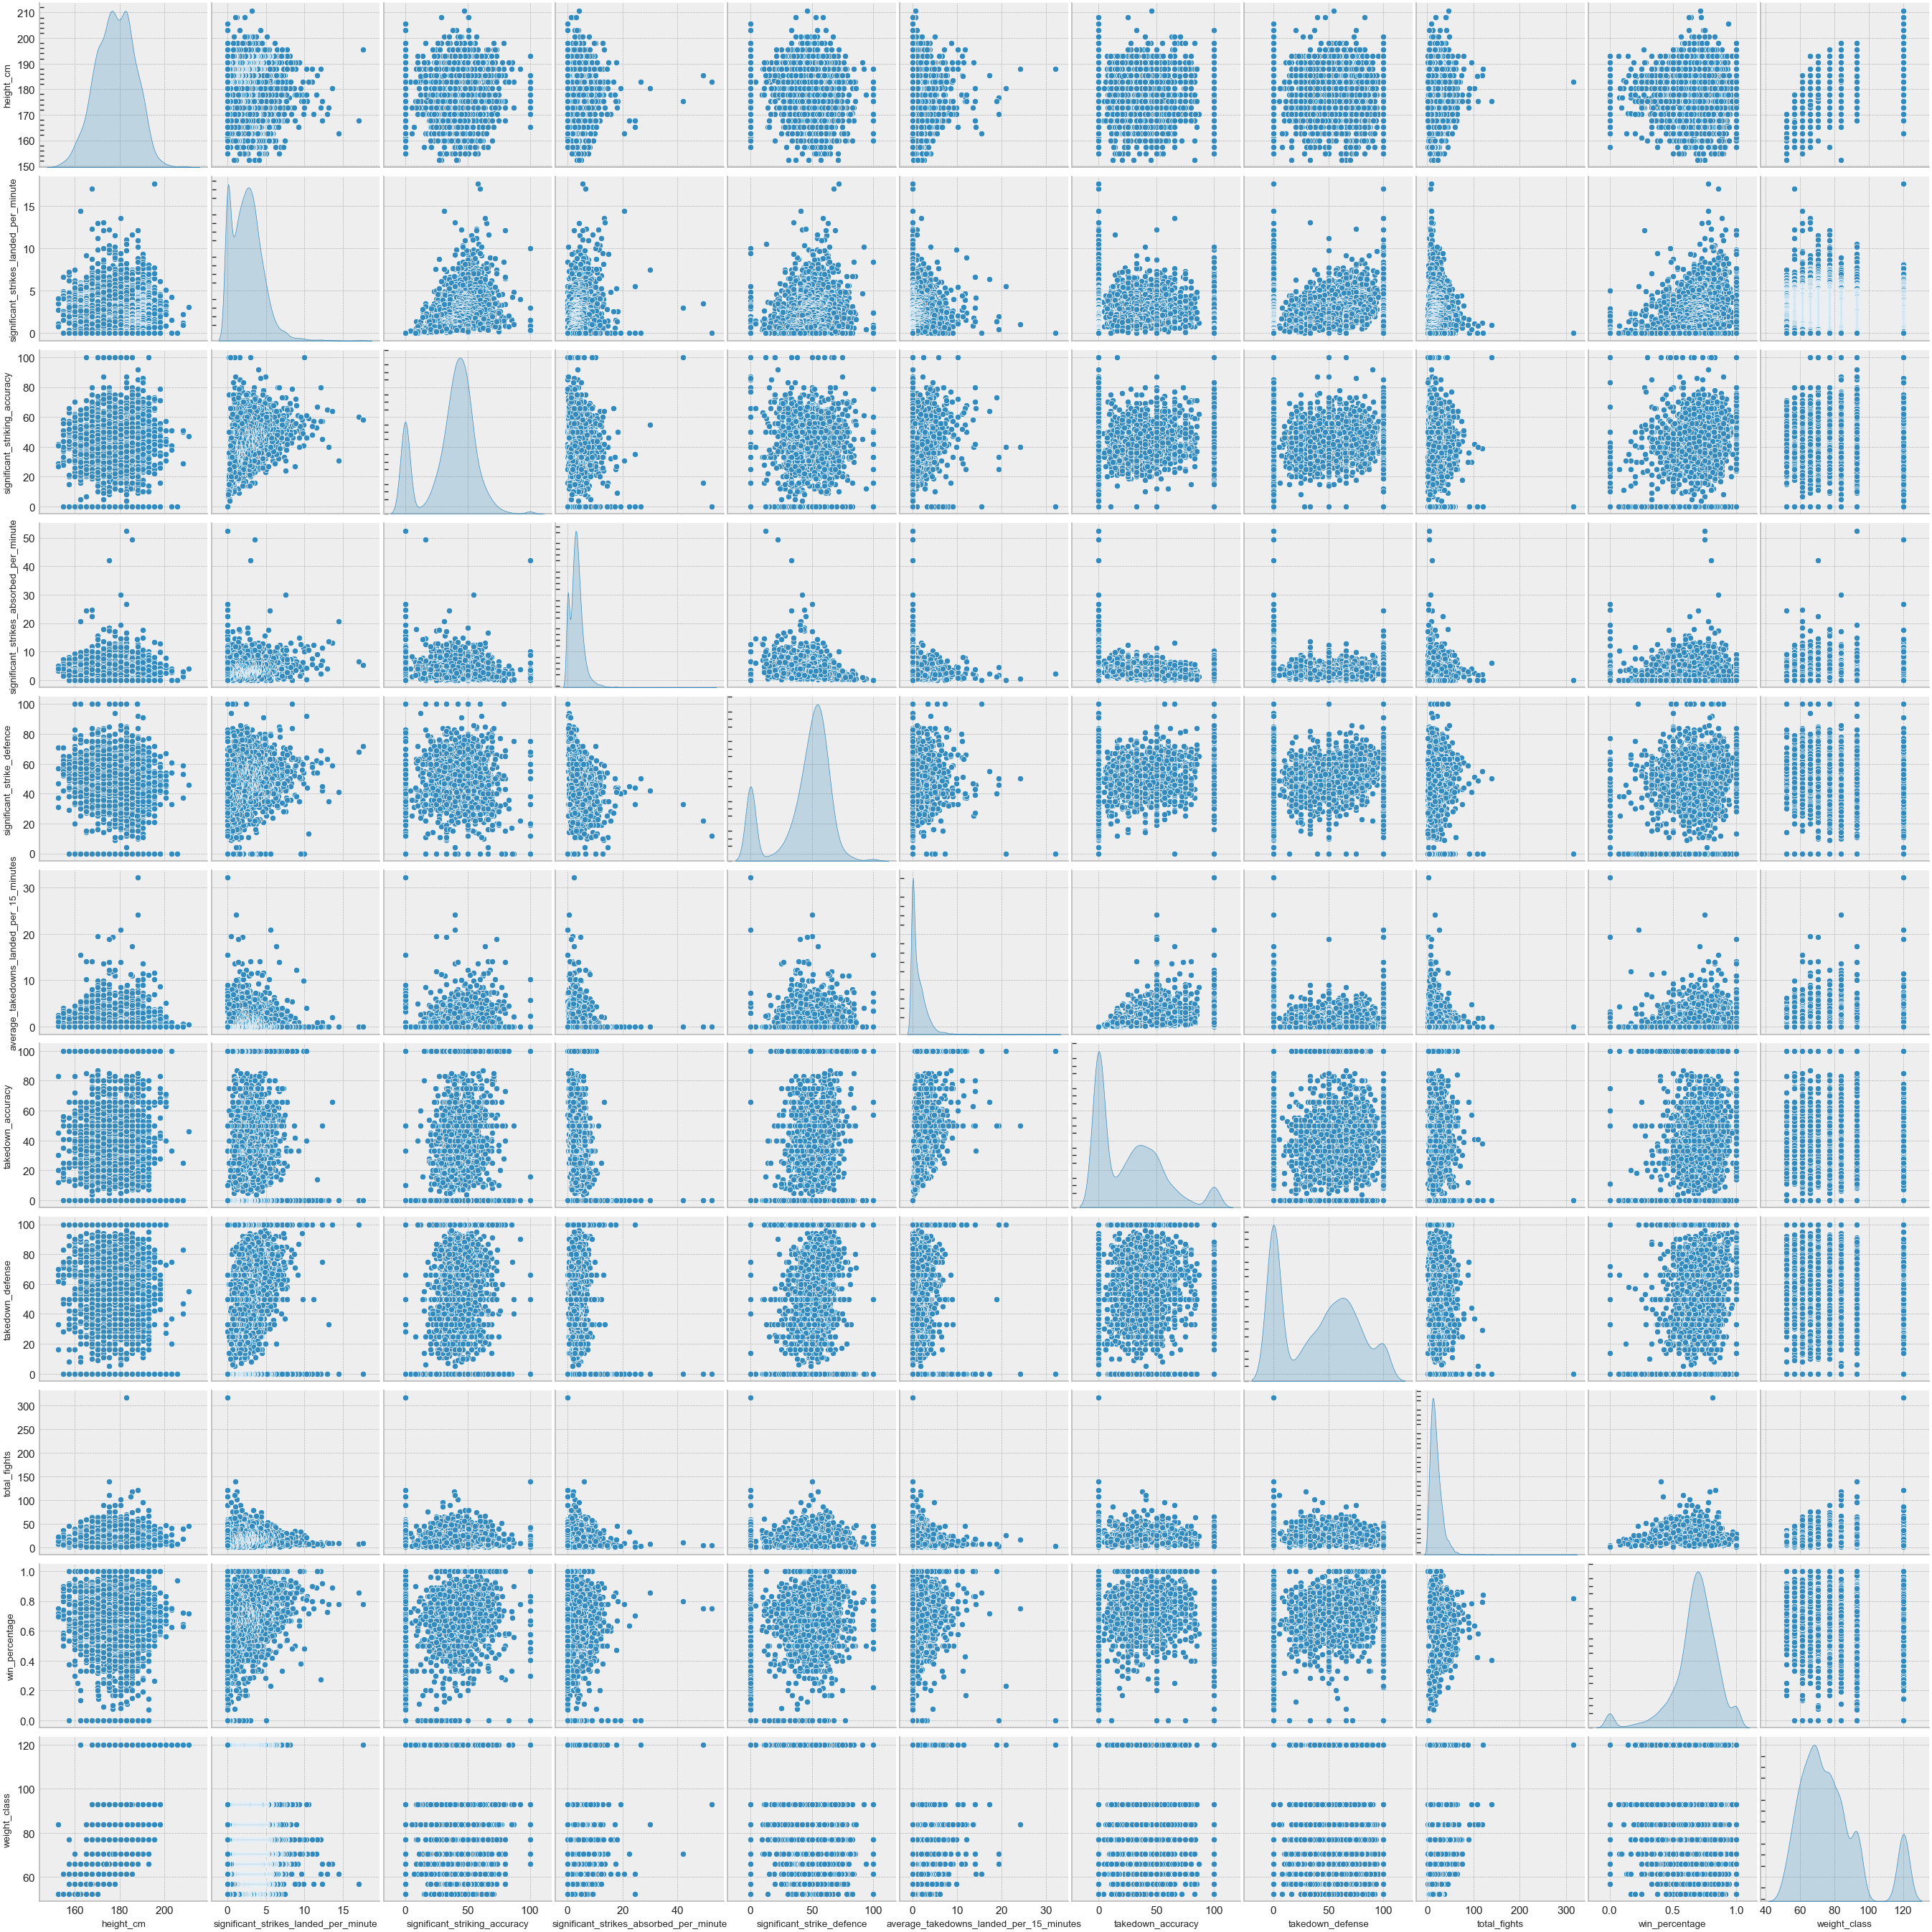

In [33]:
#print(fighter_data.columns)
data = fighter_data.drop(columns=['nickname', 'wins', 'losses', 'draws', 'average_submissions_attempted_per_15_minutes'])
p3 = sns.pairplot(data, diag_kind='kde')

C:\Users\noahl\AppData\Local\Temp\ipykernel_24508\2038269003.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  p4 = sns.heatmap(data.corr(), annot=True, fmt = ".2f", cmap = "plasma")


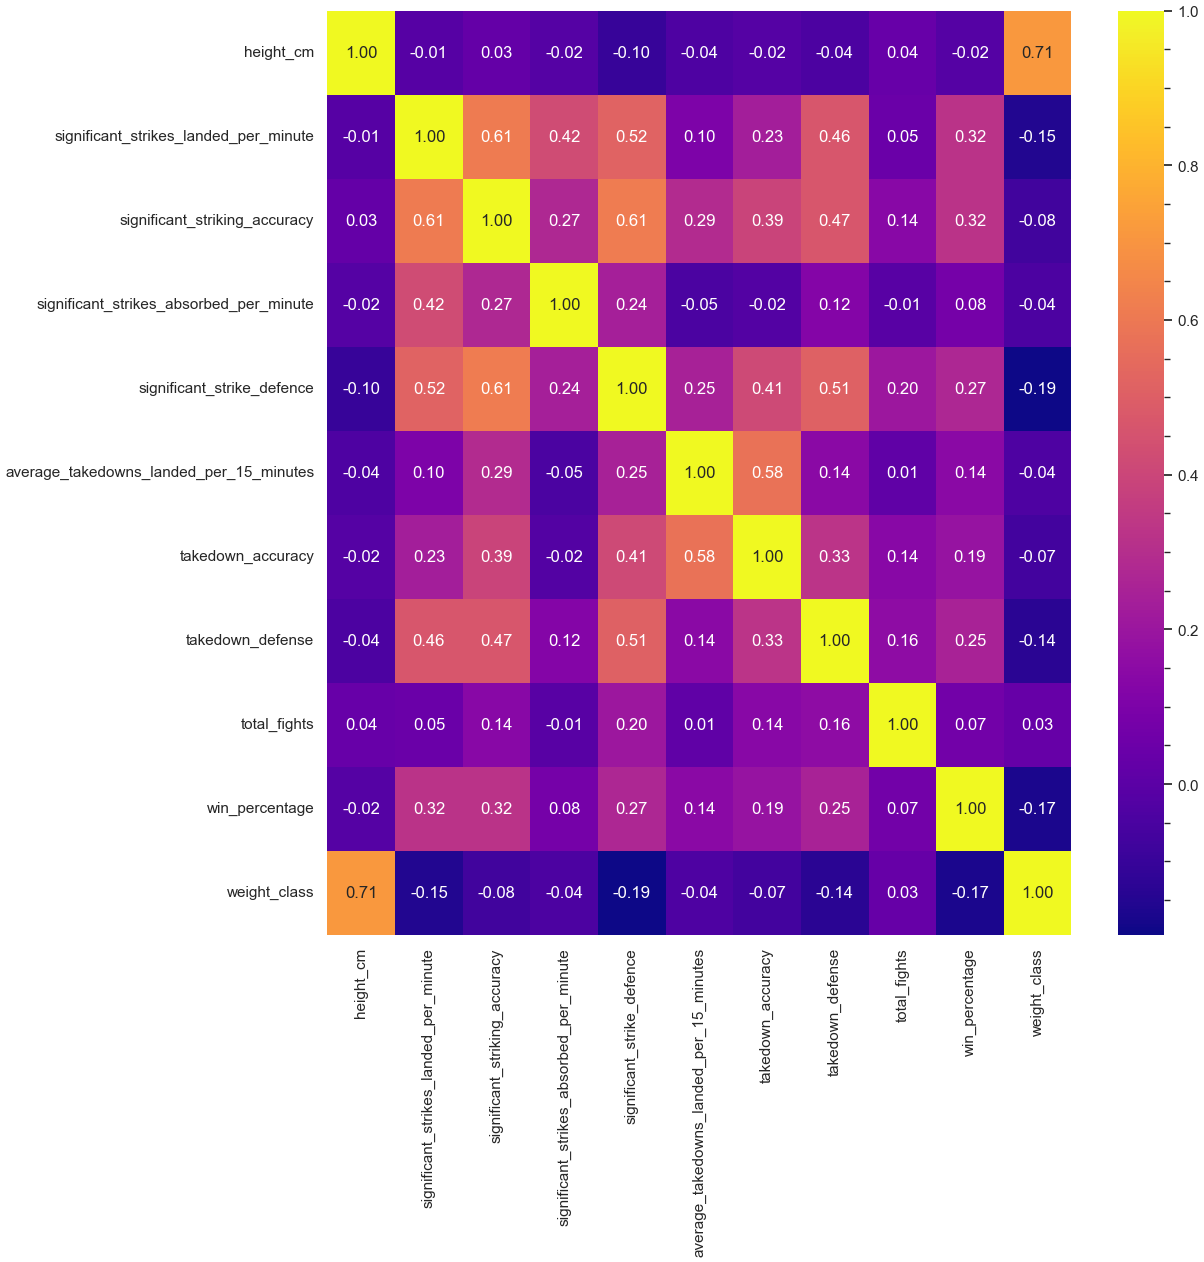

In [35]:
p4 = sns.heatmap(data.corr(), annot=True, fmt = ".2f", cmap = "plasma")
sns.set(rc={'figure.figsize':(12,12)})
p4.tick_params(axis = 'x', rotation = 90)
p4.tick_params(axis = 'y', rotation = 0)

In [41]:
data = data[data['total_fights'] != 316]

### Model Building and Analysis

To execute stepwise refinement, I inserted all the allowable features into a list and iterated through the list to find the model with the highest R square value that was still significant at the p = .05 level. Then I removed the chosen feature from the list of features and iterated through a new model containing all previously identified best features plus a new feature for consideration. I used the statsmodels.formula.api.ols function to perform the regression. After training on the training data I then trained the test data on the same variables. 

For my first stepwise refinement model I was attempting to predict the winning percentage of the fighter.  the R-squared value was low, only .107; however, the P value was significant at the .05 level, so the best model produced, using significant striking accuracy, has some meaning, but needs more variables to become more usable. The next factors selected through this process were significant strikes landed per minute, takedown defense, significant strikes absorbed per minute, significant strike defense, and average takedowns landed per minute. Through the process of forward stepwise refinement the P values did not fail the significance test at .05 until the k = 7 step which selected height. Therefore, I stopped the win percentage model at k = 6. Here we also began to get warning of collinearity from the OLS Regression summary, which can be validated by the negative regression coefficient for height. The common refrain is that height and, subsequently, reach are an advantage to combatants. The negative coefficient, insignificant p value and high condition number all point to some collinearity in the k = 7 model. 

The maximum adjusted R-squared value for this model was .146. The R-squared values increased with each feature added showing that they were accounting for more of the data variance as the model complexity increases. The adjusted R-squared values of for the test data were lower, but followed the same pattern generally as the adjusted R-squared values for the training data which provides some validity to the model trained. Regardless of the potential combinations with the features we could not account for enough variability to make a truly meaningful model. Despite this the traits that correlated strongest to winning were offensive traits of significant strike accuracy and significant strikes landed per minute. If you could injure or knock out your opponent then you were more likely to win the match which is very logical.


In [44]:
#Split the data into training data and testing/validation data using the typical 80/20 ratio
train_data, test_data = train_test_split(data, train_size=.8)


3173 794


In [57]:
#Begin Forward Stepwise Refinement for Winning Percentage
allowed_factors = ['height_cm', 'significant_strikes_landed_per_minute', 'significant_striking_accuracy', 'significant_strikes_absorbed_per_minute',
                   'significant_strike_defence', 'average_takedowns_landed_per_15_minutes', 'takedown_accuracy', 'takedown_defense']
# k = 1
best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='win_percentage~'+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model1 = best_model

height_cm 0.001685900004067875
stance 0.049158909142955176
significant_strikes_landed_per_minute 0.10722142408305102
significant_striking_accuracy 0.1076948299989009
significant_strikes_absorbed_per_minute 0.005878120092639105
significant_strike_defence 0.07927061004142477
average_takedowns_landed_per_15_minutes 0.01665685205276568
takedown_accuracy 0.03598817309461366
takedown_defense 0.06788673935726686
best: ['significant_striking_accuracy', 0.1076948299989009]
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     382.7
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.49e-80
Time:                        13:31:10   Log-Likelihood:                 1059.3
No. Observations:                3173   AIC:             

In [58]:
# k = 2
best = ['',0]
allowed_factors = ['height_cm', 'significant_strikes_landed_per_minute', 'significant_strikes_absorbed_per_minute',
                   'significant_strike_defence', 'average_takedowns_landed_per_15_minutes', 'takedown_accuracy', 'takedown_defense']
for p in allowed_factors:
    model = smf.ols(formula='win_percentage~significant_striking_accuracy + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model2 = best_model

height_cm 0.11040961543779604
stance 0.11703380113921169
significant_strikes_landed_per_minute 0.13375187706836822
significant_strikes_absorbed_per_minute 0.10779133728324941
significant_strike_defence 0.11850593357059713
average_takedowns_landed_per_15_minutes 0.10943083678920817
takedown_accuracy 0.11223758573825116
takedown_defense 0.12180032365194593
best: ['significant_strikes_landed_per_minute', 0.13375187706836822]
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     244.7
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.46e-99
Time:                        13:31:24   Log-Likelihood:                 1106.3
No. Observations:                3173   AIC:                            -2207.
Df Residuals:        

In [59]:
# k = 3
best = ['',0]
allowed_factors = ['height_cm', 'significant_strikes_absorbed_per_minute',
                   'significant_strike_defence', 'average_takedowns_landed_per_15_minutes', 'takedown_accuracy', 'takedown_defense']
for p in allowed_factors:
    model = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model3 = best_model

height_cm 0.13576475302015212
stance 0.13962861530687132
significant_strikes_absorbed_per_minute 0.13826070035646876
significant_strike_defence 0.13857471669378152
average_takedowns_landed_per_15_minutes 0.137016834059691
takedown_accuracy 0.13857836828160464
takedown_defense 0.14018636616420987
best: ['takedown_defense', 0.14018636616420987]
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     172.2
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          1.95e-103
Time:                        13:31:32   Log-Likelihood:                 1118.1
No. Observations:                3173   AIC:                            -2228.
Df Residuals:                    3169   BIC:                            -2204.
Df Model:              

In [60]:
# k = 4
best = ['',0]
allowed_factors = ['height_cm', 'significant_strikes_absorbed_per_minute',
                   'significant_strike_defence', 'average_takedowns_landed_per_15_minutes', 'takedown_accuracy']
for p in allowed_factors:
    model = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute +  takedown_defense + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model4 = best_model

height_cm 0.1416770784158501
significant_strikes_absorbed_per_minute 0.14361478930242966
significant_strike_defence 0.14263186913738457
average_takedowns_landed_per_15_minutes 0.14289880967595558
takedown_accuracy 0.1431759088006349
best: ['significant_strikes_absorbed_per_minute', 0.14361478930242966]
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     132.8
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          5.09e-105
Time:                        13:31:41   Log-Likelihood:                 1124.5
No. Observations:                3173   AIC:                            -2239.
Df Residuals:                    3168   BIC:                            -2209.
Df Model:                           4                           

In [61]:
# k = 5
best = ['',0]
allowed_factors = ['height_cm', 'significant_strike_defence', 'average_takedowns_landed_per_15_minutes', 'takedown_accuracy']
for p in allowed_factors:
    model = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute +  takedown_defense + significant_strikes_absorbed_per_minute +'+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model5 = best_model

height_cm 0.145206702088013
significant_strike_defence 0.14629751985795203
average_takedowns_landed_per_15_minutes 0.14577096922013444
takedown_accuracy 0.14583506185530082
best: ['significant_strike_defence', 0.14629751985795203]
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     108.5
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          4.47e-106
Time:                        13:31:49   Log-Likelihood:                 1129.4
No. Observations:                3173   AIC:                            -2247.
Df Residuals:                    3167   BIC:                            -2210.
Df Model:                           5                                         
Covariance Type:            nonrobust                     

In [62]:
# k = 6
best = ['',0]
allowed_factors = ['height_cm', 'average_takedowns_landed_per_15_minutes', 'takedown_accuracy']
for p in allowed_factors:
    model = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute +  takedown_defense + significant_strikes_absorbed_per_minute + significant_strike_defence +'+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model6 = best_model

height_cm 0.1473604323634945
average_takedowns_landed_per_15_minutes 0.14798100338600273
takedown_accuracy 0.14770161724378794
best: ['average_takedowns_landed_per_15_minutes', 0.14798100338600273]
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     91.65
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          2.21e-106
Time:                        13:31:59   Log-Likelihood:                 1132.6
No. Observations:                3173   AIC:                            -2251.
Df Residuals:                    3166   BIC:                            -2209.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
            

In [55]:
# k = 7
best = ['',0]
allowed_factors = ['height_cm', 'takedown_accuracy']
for p in allowed_factors:
    model = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute +  takedown_defense + significant_strikes_absorbed_per_minute + significant_strike_defence + average_takedowns_landed_per_15_minutes +'+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())

height_cm 0.14894238529480675
takedown_accuracy 0.1483374804869626
best: ['height_cm', 0.14894238529480675]
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     79.13
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          3.75e-106
Time:                        13:02:08   Log-Likelihood:                 1134.4
No. Observations:                3173   AIC:                            -2253.
Df Residuals:                    3165   BIC:                            -2204.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0

In [56]:
test_model1 = smf.ols(formula='win_percentage~significant_striking_accuracy', data=test_data).fit()
test_model2 = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute' , data=test_data).fit()
test_model3 = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute +  takedown_defense', data=test_data).fit()
test_model4 = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute +  takedown_defense + significant_strikes_absorbed_per_minute', data=test_data).fit()
test_model5 = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute +  takedown_defense + significant_strikes_absorbed_per_minute + significant_strike_defence', data=test_data).fit()
test_model6 = smf.ols(formula='win_percentage~significant_striking_accuracy + significant_strikes_landed_per_minute +  takedown_defense + significant_strikes_absorbed_per_minute + significant_strike_defence + average_takedowns_landed_per_15_minutes', data=test_data).fit()

([<matplotlib.axis.XTick at 0x26344d5b710>,
 [Text(0, 0, '$\\mathdefault{0}$'),
  Text(1, 0, '$\\mathdefault{1}$'),
  Text(2, 0, '$\\mathdefault{2}$'),
  Text(3, 0, '$\\mathdefault{3}$'),
  Text(4, 0, '$\\mathdefault{4}$'),
  Text(5, 0, '$\\mathdefault{5}$'),
  Text(6, 0, '$\\mathdefault{6}$')])

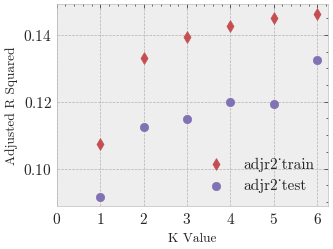

In [79]:
x = [1,2,3,4,5,6]
adjr2_train = [train_model1.rsquared_adj, train_model2.rsquared_adj, train_model3.rsquared_adj, train_model4.rsquared_adj, train_model5.rsquared_adj, train_model6.rsquared_adj]
adjr2_test = [test_model1.rsquared_adj , test_model2.rsquared_adj, test_model3.rsquared_adj, test_model4.rsquared_adj, test_model5.rsquared_adj, test_model6.rsquared_adj]
plt.scatter(x, adjr2_train, color = 'r', marker = 'd')
plt.scatter(x, adjr2_test, color = 'm')
plt.legend(['adjr2_train', 'adjr2_test'])
plt.xlabel('K Value')
plt.ylabel('Adjusted R Squared')
plt.xticks(np.arange(0, 7, 1))

### Model Building and Analysis Continued
For the next model I also created a stepwise refinement. This time I was attempting to predict the longevity of the fighter based on their fight style and physical traits through the total fights feature. As before I continued to add features to the regression until the feature lost its significance at the p = .05 level. This model also stopped at the k = 6 level. The features selected were significant strike defense, significant strikes landed per minute, takedown defense, takedown accuracy, average takedowns landed per 15 minutes, weight class, and significant strikes absorbed per minute. The model did not invert at any point or receive a warning regarding a high condition number so it is unlikely that there is any collinearity between features considered for this model. Based on this height is the only collinear feature as it was the only anomalous feature in either regression model. The models created using both the test and training data followed a similar pattern for R-squared values; however, in this model the test validation models were higher meaning that they explained more of the variability. This could indicate that the model was overfit. 

To test the overfitting theory I split the data again using a smaller set of training data, only 250 samples rather than the original 3200 (80% of the data). I got very similar R-squared values as the validation data from the prior model, and the larger test data, now containing some 3700 samples getting similar results as the large test data used previously. This consistent increase in accounting for variability by almost 33% higher than the larger sample reflected in the increased R-square values tells me that the model overfits when it has this much data.

The traits that had the highest relationship to fighter longevity were significant strike defense, significant strikes landed per minute and takedown defense. These are all very logical. The two defensive statistics correlated positively with longevity which shows that the expected number of fights in a fighters career would increase if they were good at avoiding being hit or taken down. The significant strikes landed correlated negatively with fighter longevity which is also logical. When striking you are opening yourself up to your opponents strikes and are therefore more likely to be hit yourself. This is also reflected in the heat map which shows these two stats more correlated than any particular stat was correlated to winning.
 

In [93]:
# k = 1
allowed_factors = ['height_cm', 'weight_class', 'significant_strikes_landed_per_minute', 'significant_striking_accuracy', 'significant_strikes_absorbed_per_minute',
                   'significant_strike_defence', 'average_takedowns_landed_per_15_minutes', 'takedown_accuracy', 'takedown_defense']

best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='total_fights~'+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model1 = best_model

height_cm 0.0009526643071698926
weight_class 0.0003290657594517965
significant_strikes_landed_per_minute 0.0016710025242744342
significant_striking_accuracy 0.017682608362424412
significant_strikes_absorbed_per_minute 0.0003212892396120548
significant_strike_defence 0.045489516328628965
average_takedowns_landed_per_15_minutes 0.0007432536919559363
takedown_accuracy 0.0245372891232839
takedown_defense 0.027294298052672916
best: ['significant_strike_defence', 0.045489516328628965]
                            OLS Regression Results                            
Dep. Variable:           total_fights   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     151.1
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           5.78e-34
Time:                        15:59:20   Log-Likelihood:                -12411.
No. Observations:                3173   AI

In [94]:
# k = 2
allowed_factors = ['height_cm', 'weight_class', 'significant_strikes_landed_per_minute', 'significant_striking_accuracy', 'significant_strikes_absorbed_per_minute',
                   'average_takedowns_landed_per_15_minutes', 'takedown_accuracy', 'takedown_defense']

best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='total_fights~significant_strike_defence + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model2 = best_model

height_cm 0.048592375837113067
weight_class 0.04953803647217914
significant_strikes_landed_per_minute 0.05171530420674941
significant_striking_accuracy 0.045511758745161224
significant_strikes_absorbed_per_minute 0.04995065532010712
average_takedowns_landed_per_15_minutes 0.04604847325519568
takedown_accuracy 0.05147282807348452
takedown_defense 0.04984550879969962
best: ['significant_strikes_landed_per_minute', 0.05171530420674941]
                            OLS Regression Results                            
Dep. Variable:           total_fights   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     86.44
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.80e-37
Time:                        15:59:23   Log-Likelihood:                -12401.
No. Observations:                3173   AIC:                         2.481e+04
Df Residua

In [95]:
# k = 3
allowed_factors = ['height_cm', 'weight_class', 'significant_striking_accuracy', 'significant_strikes_absorbed_per_minute',
                   'average_takedowns_landed_per_15_minutes', 'takedown_accuracy', 'takedown_defense']

best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model3 = best_model

height_cm 0.05528554801459984
weight_class 0.055191773634040375
significant_striking_accuracy 0.05359782520517542
significant_strikes_absorbed_per_minute 0.053416572524701
average_takedowns_landed_per_15_minutes 0.05240573179280761
takedown_accuracy 0.058039436027372826
takedown_defense 0.06015150819531412
best: ['takedown_defense', 0.06015150819531412]
                            OLS Regression Results                            
Dep. Variable:           total_fights   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     67.61
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.26e-42
Time:                        15:59:25   Log-Likelihood:                -12387.
No. Observations:                3173   AIC:                         2.478e+04
Df Residuals:                    3169   BIC:                         2.481e+04
Df Model:   

In [96]:
# k = 4
allowed_factors = ['height_cm', 'weight_class', 'significant_striking_accuracy', 'significant_strikes_absorbed_per_minute',
                   'average_takedowns_landed_per_15_minutes', 'takedown_accuracy']

best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + takedown_defense + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model4 = best_model

height_cm 0.06393329956387328
weight_class 0.06407294087945836
significant_striking_accuracy 0.06109182547730241
significant_strikes_absorbed_per_minute 0.06110371800334924
average_takedowns_landed_per_15_minutes 0.061172890456107964
takedown_accuracy 0.06438150289740263
best: ['takedown_accuracy', 0.06438150289740263]
                            OLS Regression Results                            
Dep. Variable:           total_fights   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     54.50
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.71e-44
Time:                        15:59:28   Log-Likelihood:                -12379.
No. Observations:                3173   AIC:                         2.477e+04
Df Residuals:                    3168   BIC:                         2.480e+04
Df Model:                           4          

In [97]:
# k = 5
allowed_factors = ['height_cm', 'weight_class', 'significant_striking_accuracy', 'significant_strikes_absorbed_per_minute',
                   'average_takedowns_landed_per_15_minutes']

best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + takedown_defense + takedown_accuracy + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model5 = best_model

height_cm 0.06786630897014878
weight_class 0.06803257425124087
significant_striking_accuracy 0.06473180907471687
significant_strikes_absorbed_per_minute 0.06486658649099153
average_takedowns_landed_per_15_minutes 0.07083515947060204
best: ['average_takedowns_landed_per_15_minutes', 0.07083515947060204]
                            OLS Regression Results                            
Dep. Variable:           total_fights   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     48.29
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.70e-48
Time:                        15:59:31   Log-Likelihood:                -12368.
No. Observations:                3173   AIC:                         2.475e+04
Df Residuals:                    3167   BIC:                         2.479e+04
Df Model:                           5                           

In [98]:
# k = 6
allowed_factors = ['height_cm', 'weight_class', 'significant_striking_accuracy', 'significant_strikes_absorbed_per_minute']

best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + takedown_defense + takedown_accuracy + average_takedowns_landed_per_15_minutes + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model6 = best_model

height_cm 0.07395765351952566
weight_class 0.07432849609687076
significant_striking_accuracy 0.07160774842427475
significant_strikes_absorbed_per_minute 0.07141871571618119
best: ['weight_class', 0.07432849609687076]
                            OLS Regression Results                            
Dep. Variable:           total_fights   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     42.37
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           5.61e-50
Time:                        15:59:34   Log-Likelihood:                -12362.
No. Observations:                3173   AIC:                         2.474e+04
Df Residuals:                    3166   BIC:                         2.478e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                   

In [99]:
# k = 7
allowed_factors = ['height_cm', 'significant_striking_accuracy', 'significant_strikes_absorbed_per_minute']

best = ['',0]
for p in allowed_factors:
    model = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + takedown_defense + takedown_accuracy + average_takedowns_landed_per_15_minutes + weight_class + '+p, data=train_data).fit()
    print(p, model.rsquared)
    if model.rsquared>best[1]:
        best = [p, model.rsquared]
        best_model = model
print('best:',best)
print(best_model.summary())
train_model7 = best_model

height_cm 0.07471498609951754
significant_striking_accuracy 0.07478413162017916
significant_strikes_absorbed_per_minute 0.07501345891013989
best: ['significant_strikes_absorbed_per_minute', 0.07501345891013989]
                            OLS Regression Results                            
Dep. Variable:           total_fights   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     36.67
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.21e-49
Time:                        15:59:44   Log-Likelihood:                -12361.
No. Observations:                3173   AIC:                         2.474e+04
Df Residuals:                    3165   BIC:                         2.479e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         

In [101]:
test_model1 = smf.ols(formula='total_fights~significant_strike_defence', data=test_data).fit()
test_model2 = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute' , data=test_data).fit()
test_model3 = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + takedown_defense', data=test_data).fit()
test_model4 = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + takedown_defense + takedown_accuracy', data=test_data).fit()
test_model5 = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + takedown_defense + takedown_accuracy + average_takedowns_landed_per_15_minutes', data=test_data).fit()
test_model6 = smf.ols(formula='total_fights~significant_strike_defence + significant_strikes_landed_per_minute + takedown_defense + takedown_accuracy + average_takedowns_landed_per_15_minutes + weight_class', data=test_data).fit()

([<matplotlib.axis.XTick at 0x2634869ea50>,
 [Text(0, 0, '$\\mathdefault{0}$'),
  Text(1, 0, '$\\mathdefault{1}$'),
  Text(2, 0, '$\\mathdefault{2}$'),
  Text(3, 0, '$\\mathdefault{3}$'),
  Text(4, 0, '$\\mathdefault{4}$'),
  Text(5, 0, '$\\mathdefault{5}$'),
  Text(6, 0, '$\\mathdefault{6}$')])

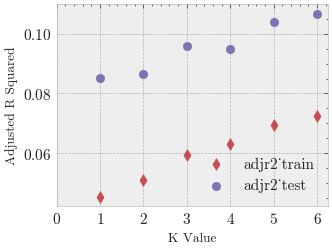

In [102]:
x = [1,2,3,4,5,6]
adjr2_train = [train_model1.rsquared_adj, train_model2.rsquared_adj, train_model3.rsquared_adj, train_model4.rsquared_adj, train_model5.rsquared_adj, train_model6.rsquared_adj]
adjr2_test = [test_model1.rsquared_adj , test_model2.rsquared_adj, test_model3.rsquared_adj, test_model4.rsquared_adj, test_model5.rsquared_adj, test_model6.rsquared_adj]
plt.scatter(x, adjr2_train, color = 'r', marker = 'd')
plt.scatter(x, adjr2_test, color = 'm')
plt.legend(['adjr2_train', 'adjr2_test'])
plt.xlabel('K Value')
plt.ylabel('Adjusted R Squared')
plt.xticks(np.arange(0, 7, 1))

### Conclusion
I learned a lot through this exercise. Some things are likely too complex to model purely through regression. A model can be logically constructed and pass p tests but still not adequately explain the variance of the data enough to be useful as was the case with these two models. The first model never reached an R-squared value above .146 even though it maintained low p values for the 6 features it incorporated. The second model never reached an R-squared value above .108 even after accounting for the overfitting. Both R-Squared values are too low to take away any significant conclusions from the model even if their most heavily weighted attributes do make logical sense. 

Any future analysis on this topic certainly needs to increase the number of features available for analysis. Combat sports are extremely complex and there are no 10 data points that could explain a fighters career. There can also be a variety of things outside of the fights themselves that shortens a fighters career from politics, personal conduct, unrelated injuries, other personal issues, or commercial viability of the fighter. Getting data or quantifying all these categories would be difficult and much of it would never be released to the public. It is likely that any model would struggle to reach an R-squared value in the .8+ range because of this complexity.

To improve this analysis, I would start by getting submission data and reach data. I think that lacking submission data was very harmful to the creation of the model. Successful submissions are an immediate win and the criteria for being awarded a submission attempt is stringent, so having either of these data points would likely help the models significantly. Another missing data point that is likely very important is fighter reach. Fighters with above average reach are perceived to have a natural advantage in their fights. If this were true then it would likely give the models a better ability to explain winning percentage and fighter longevity. 
